In [1]:
from rockpool.devices.xylo.syns65302 import AFESim, AUDIO_SAMPLING_RATE, ChipButterworth, DivisiveNormalization
import librosa
import matplotlib.pyplot as plt
import numpy as np
from rockpool.timeseries import TSContinuous, TSEvent

from samna.xyloA3.configuration import InputInterfaceConfig


In [2]:
# import numpy as np
# import scipy.io.wavfile
# import matplotlib.pyplot as plt

# # Sampling parameters
# fs = int(AUDIO_SAMPLING_RATE)  # Sampling rate in Hz
# T = 10.0     # seconds
# t = np.linspace(0, T, int(T*fs), endpoint=False)  # time variable

# # create a frequency sweep from 20 to 20000 Hz

# start_freq = 20.0  # in Hz
# end_freq = 20000.0  # in Hz
# freq_sweep = np.linspace(start_freq, end_freq, int(T*fs), endpoint=False)
# phi_inst = 2 * np.pi * np.cumsum(freq_sweep) * (1/fs)
# signal = np.sin(phi_inst)

# # ensure that highest values are in 16-bit range
# audio = np.int16(signal/np.max(np.abs(signal)) * 32767)

# # save as wave file
# scipy.io.wavfile.write('freq_sweep.wav', fs, audio)


## Load the audio file

In [3]:
filename = 'freq_sweep.wav'
y, sr = librosa.load(filename, sr=None)  # sr=None preserves the original sampling rate

## Quantize the signal to 14 bits

In [4]:
scale = 1
num_bits = 14
q_signal = np.vectorize(lambda __data : int(scale * __data * (2 ** (num_bits - 1))), )(y)

## Apply filters

In [5]:
filter_bank = ChipButterworth()

In [6]:
filtered, _, _ = filter_bank(q_signal)

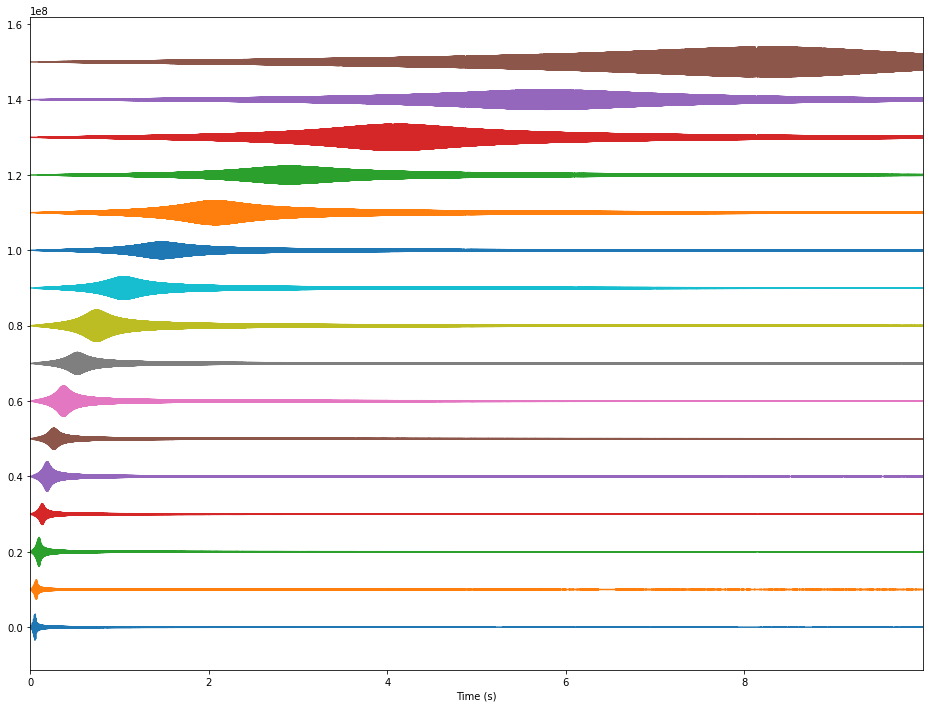

In [7]:
plt.figure(figsize=(16, 12))
TSContinuous.from_clocked(filtered, dt=1/sr).plot(stagger=1e7)
plt.show()

## Apply Divisive Normalization

In [8]:
divisive_norm = DivisiveNormalization()

In [9]:
spike_out, _, _ = divisive_norm(filtered)

WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:335: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)
 [py.warnings]
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)

WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:337: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.c

  jnp.zeros(num_channels, dtype=jnp.int64),



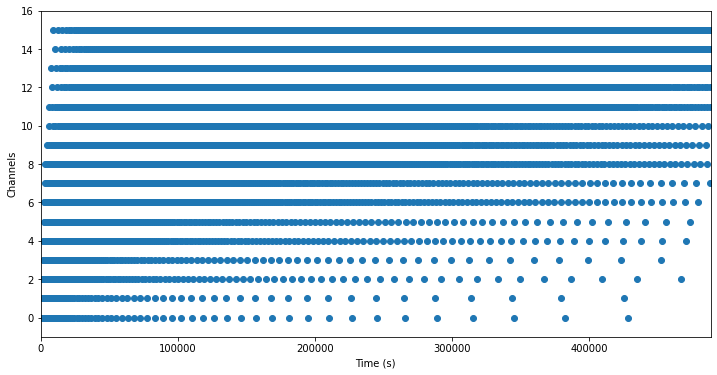

In [10]:
plt.figure(figsize=(12, 6))
TSEvent.from_raster(spike_out).plot()